In [1]:
from theano.sandbox import cuda
cuda.use('gpu2')

Using gpu device 2: GeForce GTX TITAN X (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 4007)


In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)
/usr/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


## Setup

In [2]:
path = "/input/"
model_path = os.path.join(os.getcwd() + '/models/')
if not os.path.exists(model_path): os.mkdir(model_path)

In [3]:
train = pd.read_csv(path+'train.csv').values
test = pd.read_csv(path+'test.csv').values

In [4]:
train, train_label = train[:,1:], train[:,0]
train = train.astype('float32')
split_size = int(train.shape[0]*0.85)
X_train, X_val = train[:split_size, :], train[split_size:, :]
y_train, y_val = train_label[:split_size].reshape(-1,1), train_label[split_size:].reshape(-1,1)

In [5]:
X_train = X_train.reshape(-1,1,28,28)
X_val = X_val.reshape(-1,1,28,28)

In [6]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [7]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

In [8]:
# Global Contrast Normalization
def norm_input(x): return (x-mean_px)/std_px

In [9]:
gen = image.ImageDataGenerator()
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [10]:
X_train.shape, X_val.shape

((35700, 1, 28, 28), (6300, 1, 28, 28))

In [11]:
y_train.shape, y_val.shape

((35700, 10), (6300, 10))

## ConvNet

In [12]:
import keras.callbacks as kcb
class CallMetric(kcb.Callback):
    def on_train_begin(self, logs={}):
        self.best_acc = 0.0
        self.accs = []
        self.val_accs = []
        self.losses = []
        self.val_losses = []
    def on_epoch_end(self, batch, logs={}):
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        if logs.get('val_acc') > self.best_acc:
            self.best_acc = logs.get('val_acc')
            print("\nThe BEST val_acc to date.")

metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath="./cnn_6l.h5", monitor='val_acc', verbose=1, save_best_only=True)

In [21]:
def get_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),
        Convolution2D(16,3,3, activation='relu'),
        Convolution2D(16,3,3, activation='relu'),
        MaxPooling2D(),
        Convolution2D(32,3,3, activation='relu'),
        Convolution2D(32,3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, init='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(512, init='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
conv = get_model()

In [23]:
epochs = 14
conv.fit_generator(batches, batches.n, nb_epoch=epochs, 
                    validation_data=val_batches, nb_val_samples=val_batches.n, 
                    callbacks=[metricRecords, checkpointer])

Epoch 1/14
35636/35700 [============================>.] - ETA: 0s - loss: 0.2329 - acc: 0.9270 

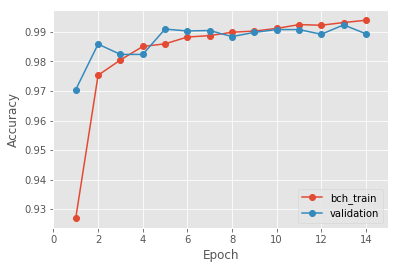

In [24]:
plt.style.use('ggplot')
plt.plot(np.arange(epochs)+1, metricRecords.accs, '-o', label='bch_train')
plt.plot(np.arange(epochs)+1, metricRecords.val_accs, '-o', label='validation')
plt.xlim(0, epochs+1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [25]:
def get_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),
        Convolution2D(32,3,3, activation='relu'),
        Convolution2D(32,3,3, activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,3,3, activation='relu'),
        Convolution2D(64,3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, init='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(512, init='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [26]:
conv = get_model()

In [27]:
epochs = 14
metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath="./cnn_6l_2timef.h5", monitor='val_acc', verbose=1, save_best_only=True)
conv.fit_generator(batches, batches.n, nb_epoch=epochs, 
                    validation_data=val_batches, nb_val_samples=val_batches.n, 
                    callbacks=[metricRecords, checkpointer])

Epoch 1/14
35572/35700 [============================>.] - ETA: 0s - loss: 0.1922 - acc: 0.9396 

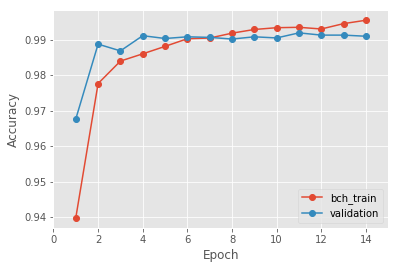

In [28]:
plt.style.use('ggplot')
plt.plot(np.arange(epochs)+1, metricRecords.accs, '-o', label='bch_train')
plt.plot(np.arange(epochs)+1, metricRecords.val_accs, '-o', label='validation')
plt.xlim(0, epochs+1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [29]:
def get_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),
        Convolution2D(32,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,3,3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, init='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(512, init='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [30]:
conv = get_model()

In [31]:
epochs = 14
metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath="./cnn_6l_all-bn.h5", monitor='val_acc', verbose=1, save_best_only=True)
conv.fit_generator(batches, batches.n, nb_epoch=epochs, 
                    validation_data=val_batches, nb_val_samples=val_batches.n, 
                    callbacks=[metricRecords, checkpointer])

Epoch 1/14
35636/35700 [============================>.] - ETA: 0s - loss: 0.1982 - acc: 0.9392 

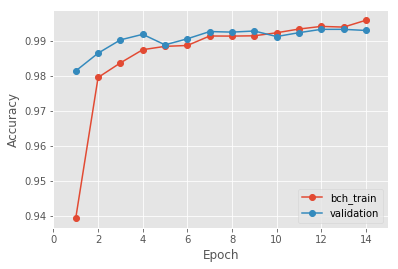

In [32]:
plt.style.use('ggplot')
plt.plot(np.arange(epochs)+1, metricRecords.accs, '-o', label='bch_train')
plt.plot(np.arange(epochs)+1, metricRecords.val_accs, '-o', label='validation')
plt.xlim(0, epochs+1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [23]:
X_test = test.reshape(-1,1,28,28)
X_test.shape, X_test.dtype

((28000, 1, 28, 28), dtype('int64'))

In [24]:
X_test = X_test.astype('float32')

In [25]:
conv.load_weights('cnn_6l_all-bn.h5')
pred_test = conv.predict_classes(X_test)

27552/28000 [============================>.] - ETA: 0s

In [26]:
submit = pd.DataFrame({ 'ImageId': np.arange(len(pred_test))+1, 'Label': pred_test })
submit.to_csv('submit_mnist.csv', index=False)
from IPython.display import HTML
HTML('<p>The submission is <a href="submit_mnist.csv">here</a>.</p>')

## Data augmentation

In [61]:
gen = image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)
#test_batches = gen.flow(X_test, y_test, batch_size=64)

In [44]:
K.set_value(conv.optimizer.lr, 0.1)

In [63]:
epochs = 8
conv.fit_generator(batches, batches.n, nb_epoch=epochs, 
                    validation_data=val_batches, nb_val_samples=val_batches.n, 
                    callbacks=[metricRecords, checkpointer])

Epoch 1/8
35508/35700 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9918     

In [65]:
gen = image.ImageDataGenerator()
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [46]:
K.set_value(conv.optimizer.lr, 0.001)

In [66]:
epochs = 3
conv.fit_generator(batches, batches.n, nb_epoch=epochs, 
                    validation_data=val_batches, nb_val_samples=val_batches.n, 
                    callbacks=[metricRecords, checkpointer])

Epoch 1/3
35520/35700 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9980 

In [41]:
epochs = 3
conv.fit_generator(batches, batches.n, nb_epoch=epochs, 
                    validation_data=val_batches, nb_val_samples=val_batches.n, 
                    callbacks=[metricRecords, checkpointer])

Epoch 1/3
35572/35700 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9966 

In [67]:
conv.save_weights('cnn_6l_all-bn.h5')

In [57]:
conv.load_weights('cnn_6l_all-bn.h5')

In [68]:
X_test = test.reshape(-1,1,28,28)
X_test.shape, X_test.dtype

((28000, 1, 28, 28), dtype('int64'))

In [69]:
X_test = X_test.astype('float32')

In [70]:
pred_test = conv.predict_classes(X_test)

27584/28000 [============================>.] - ETA: 0s

In [71]:
submit = pd.DataFrame({ 'ImageId': np.arange(len(pred_test))+1, 'Label': pred_test })
submit.to_csv('submit_mnist.csv', index=False)
from IPython.display import HTML
HTML('<p>The submission is <a href="submit_mnist.csv">here</a>.</p>')

## Ensembling

In [72]:
def fit_model():
    model = get_model()
    model.load_weights('cnn_6l_all-bn.h5')
    
    gen = image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
    batches = gen.flow(X_train, y_train, batch_size=64)
    val_batches = gen.flow(X_val, y_val, batch_size=64)
    K.set_value(model.optimizer.lr, 0.001)
    model.fit_generator(batches, batches.n, nb_epoch=12, verbose=0,
                        validation_data=val_batches, nb_val_samples=val_batches.n)
    
    return model

In [73]:
models = [fit_model() for i in range(6)]

In [74]:
preds = np.stack([m.predict(X_test, batch_size=256) for m in models])

In [76]:
avg_preds = preds.mean(axis=0)

In [78]:
pred_test = np.argmax(avg_preds, 1)

In [80]:
submit = pd.DataFrame({ 'ImageId': np.arange(len(pred_test))+1, 'Label': pred_test })
submit.to_csv('submit_mnist.csv', index=False)
from IPython.display import HTML
HTML('<p>The submission is <a href="submit_mnist.csv">here</a>.</p>')